In [3]:
import matplotlib.pyplot as plt
plt.show()

In [20]:
import matplotlib.pyplot as plt
import os, sys
from typing import Iterable, Dict, List, Callable, Tuple, Union, List

import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import fiftyone as fo
import shutil
from torchmetrics import Dice

sys.path.append('../../')
from dataset import CalgaryCampinasDataset
from model.unet import UNet2D
from model.ae import AE
from model.dae import resDAE, AugResDAE
from model.wrapper import Frankenstein, ModelAdapter
from losses import DiceScoreCalgary, SurfaceDiceCalgary
from utils import  epoch_average, UMapGenerator, volume_collate
from trainer.unet_trainer import UNetTrainerCalgary
from data_utils import (
    slice_selection, 
    dataset_from_indices,
    volume_collate
)

In [5]:
### Config
root = '../../../'
data_dir = 'data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/'
data_path = root + data_dir
debug = True
augment = False
site = 4

In [6]:
trainset = CalgaryCampinasDataset(
    data_path=data_path, 
    site=6,
    split='train',
    augment=augment, 
    normalize=True, 
    debug=debug
)

train_loader = DataLoader(
    trainset, 
    batch_size=1, 
    shuffle=False, 
    drop_last=False
)

In [24]:
seg_model   = UNet2D(n_chans_in=1, n_chans_out=1, n_filters_init=8)
criterion   = nn.BCEWithLogitsLoss(reduction='none')
eval_metrics = {
    "Volumetric Dice": DiceScoreCalgary(),
    "Surface Dice": SurfaceDiceCalgary()
}

unet_trainer = UNetTrainerCalgary(
    model=seg_model, 
    criterion=criterion, 
    train_generator=None, 
    valid_loader=None, 
    root=root, 
    eval_metrics=eval_metrics, 
    description=f'calgary_unet0_augmented',
    log=False
)

In [25]:
unet_trainer.load_model()

No metrics found


In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def slice_selection(
    dataset: Dataset, 
    indices: Tensor,
    n_cases: int = 10
) -> Tensor:
    
    slices = dataset.__getitem__(indices)['input']
    kmeans_in = slices.reshape(len(indices), -1)
    kmeans = KMeans(n_clusters=n_cases).fit(kmeans_in)
    idx, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, kmeans_in)
    return indices[idx]


def dataset_from_indices(
    dataset: Dataset, 
    indices: Tensor
) -> DataLoader:
    
    data = dataset.__getitem__(indices)
    
    class CustomDataset(Dataset):
        
        def __init__(self, input: Tensor, labels: Tensor, 
                     voxel_dim: Tensor):
            self.input = input
            self.labels = labels
            self.voxel_dim = voxel_dim
            
        def __getitem__(self, idx):
            return {'input': self.input[idx],
                    'target': self.labels[idx],
                    'voxel_dim': self.voxel_dim[idx]}
        
        def __len__(self):
            return self.input.size(0)
        
    return CustomDataset(*data.values())


@torch.no_grad()
def get_subset(
    dataset: Dataset,
    model: UNet2D,
    criterion: nn.Module,
    device: str = 'cuda:0',
    fraction: float = 0.1, 
    n_cases: int = 10, 
    part: str = "tail",
    batch_size: int = 1
) -> Dataset:
    """Selects a subset of the otherwise very large CC-359 Dataset, which
        * is in the bottom/top fraction w.r.t. to a criterion and model
        * contains n_cases, drawn to be divers w.r.t. to the input space and
          defined as k_means cluster centers, one for each case.
    """
    # TODO: cache subset indices for subsequent runs. Cache based on all
    # factors that influence selection, i.e. model, criterion, function params etc
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False
    )
    
    assert criterion.reduction == 'none'
    model.eval()
    loss_list = []
    for batch in dataloader:
        input_  = batch['input'].to(device)
        target  = batch['target'].to(device)
        net_out = model(input_)
        loss    = criterion(net_out, target).view(input_.shape[0], -1).mean(1)
        loss_list.append(loss)
        
    loss_tensor = torch.cat(loss_list)
    assert len(loss_tensor.shape) == 1
    
    indices = torch.argsort(loss_tensor, descending=True)
    len_ = len(dataset)

    devisor = int(1 / fraction)

    if part == 'tail':
        indices = indices[:len_ // devisor]
    elif part == 'head':
        indices = indices[-len_ // devisor:]   
    
    indices_selection = slice_selection(dataset, indices, n_cases=n_cases)
    subset            = dataset_from_indices(dataset, indices_selection)

    return subset

In [60]:
subset = get_subset(trainset, seg_model, criterion, batch_size=22)

In [61]:
len(subset)

10

In [18]:
criterion.reduction

'mean'

In [75]:
tmp = torch.load('../../../results-tmp/results/eval/calgary/pixel/calgary-localAug_multiImgSingleView_res_balanced_same-4-0')

In [76]:
tmp.auc_pr

0.5320814251899719

In [82]:
tmp = torch.load('../../../results-tmp/results/eval/calgary/pixel/calgary-base_prob-4-0')

In [83]:
tmp.auc_pr

0.3275090456008911

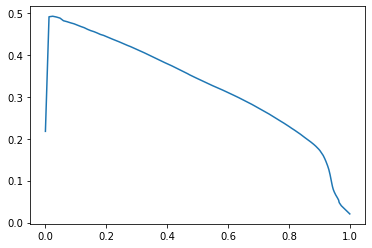

In [88]:
plt.plot(tmp.rec, tmp.pre)